In [6]:
%load_ext autoreload
%autoreload 2
from learning import trace
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from utils import *
from settings import *
from plots import plot_phoneme_responses, plot_feature_responses, plot_word_unit_responses, plot_probe_responses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
input_string = "art^st"  # Input string
slice_num = 11 + 7 * (len(input_string)-1) # Number of time slices

input_indices = get_input_indices(slice_num, input_string)

In [19]:
probes = [("art^st", 29), ("art^st", 4), ("art^st", 9)]
%prun feature_values_agg, phoneme_values_agg, word_values_agg, probe_values = trace(input_string, probes)

Time: 0, updated_slice: 4
	Center slices: [(3, 0.5), (9, 0.5), (15, 0.5), (21, 0.5), (27, 0.5), (33, 0.5), (4, 1), (10, 1), (16, 1), (22, 1), (28, 1), (34, 1), (5, 0.5), (11, 0.5), (17, 0.5), (23, 0.5), (29, 0.5), (35, 0.5)]
Time: 0, updated_slice: 9
	Center slices: [(8, 0.5), (14, 0.5), (20, 0.5), (26, 0.5), (32, 0.5), (38, 0.5), (9, 1), (15, 1), (21, 1), (27, 1), (33, 1), (39, 1), (10, 0.5), (16, 0.5), (22, 0.5), (28, 0.5), (34, 0.5), (40, 0.5)]
Time: 0, updated_slice: 29
	Center slices: [(28, 0.5), (34, 0.5), (40, 0.5), (29, 1), (35, 1), (41, 1), (30, 0.5), (36, 0.5), (42, 0.5)]
Time: 1, updated_slice: 4
	Center slices: [(3, 0.5), (9, 0.5), (15, 0.5), (21, 0.5), (27, 0.5), (33, 0.5), (4, 1), (10, 1), (16, 1), (22, 1), (28, 1), (34, 1), (5, 0.5), (11, 0.5), (17, 0.5), (23, 0.5), (29, 0.5), (35, 0.5)]
Time: 1, updated_slice: 9
	Center slices: [(8, 0.5), (14, 0.5), (20, 0.5), (26, 0.5), (32, 0.5), (38, 0.5), (9, 1), (15, 1), (21, 1), (27, 1), (33, 1), (39, 1), (10, 0.5), (16, 0.5), (22

         494909 function calls (493716 primitive calls) in 21.288 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1988   17.052    0.009   17.135    0.009 {built-in method time.sleep}
  606/414    0.657    0.001    0.004    0.000 {built-in method posix.read}
      505    0.612    0.001    0.620    0.001 {method 'poll' of 'select.poll' objects}
      138    0.496    0.004    0.923    0.007 cloudpickle.py:338(_find_imported_submodules)
   217304    0.415    0.000    0.415    0.000 {method 'startswith' of 'str' objects}
      183    0.404    0.002   20.612    0.113 process_executor.py:671(wait_result_broken_or_wakeup)
      139    0.212    0.002    0.212    0.002 {method 'poll' of 'select.epoll' objects}
    20794    0.044    0.000    0.044    0.000 {built-in method builtins.len}
     1702    0.042    0.000    0.046    0.000 {built-in method _pickle.dumps}
      138    0.041    0.000    1.545    0.011 {function Pickler.du

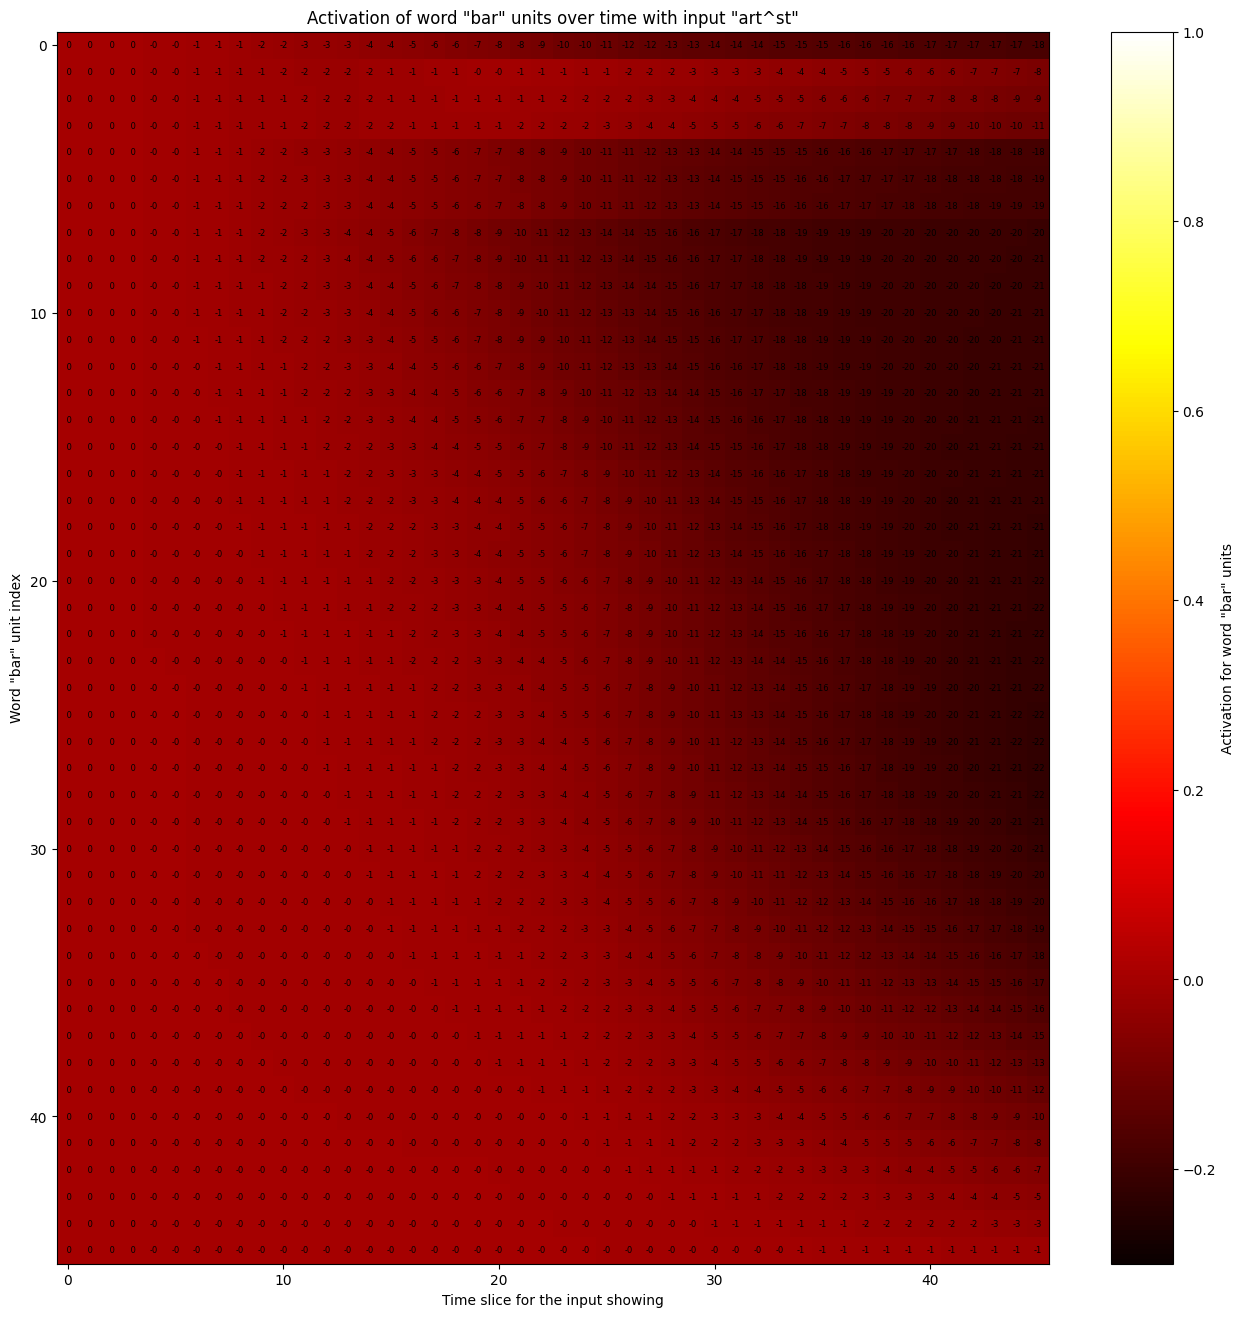

(46,)


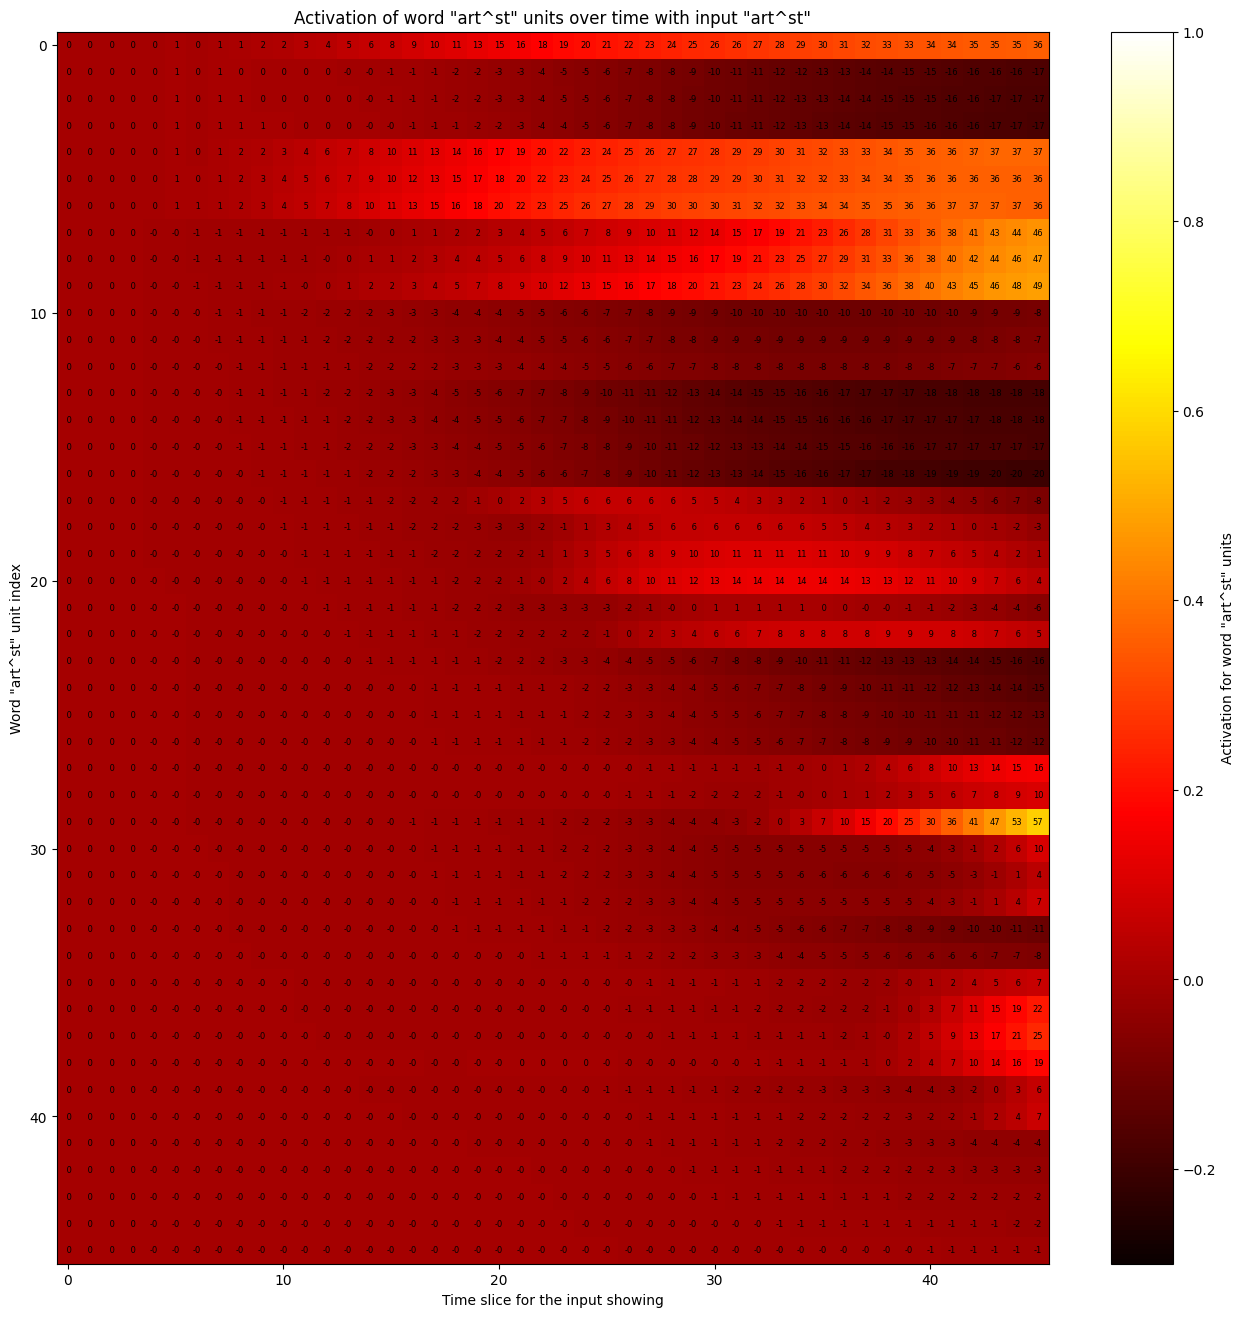

(46,)


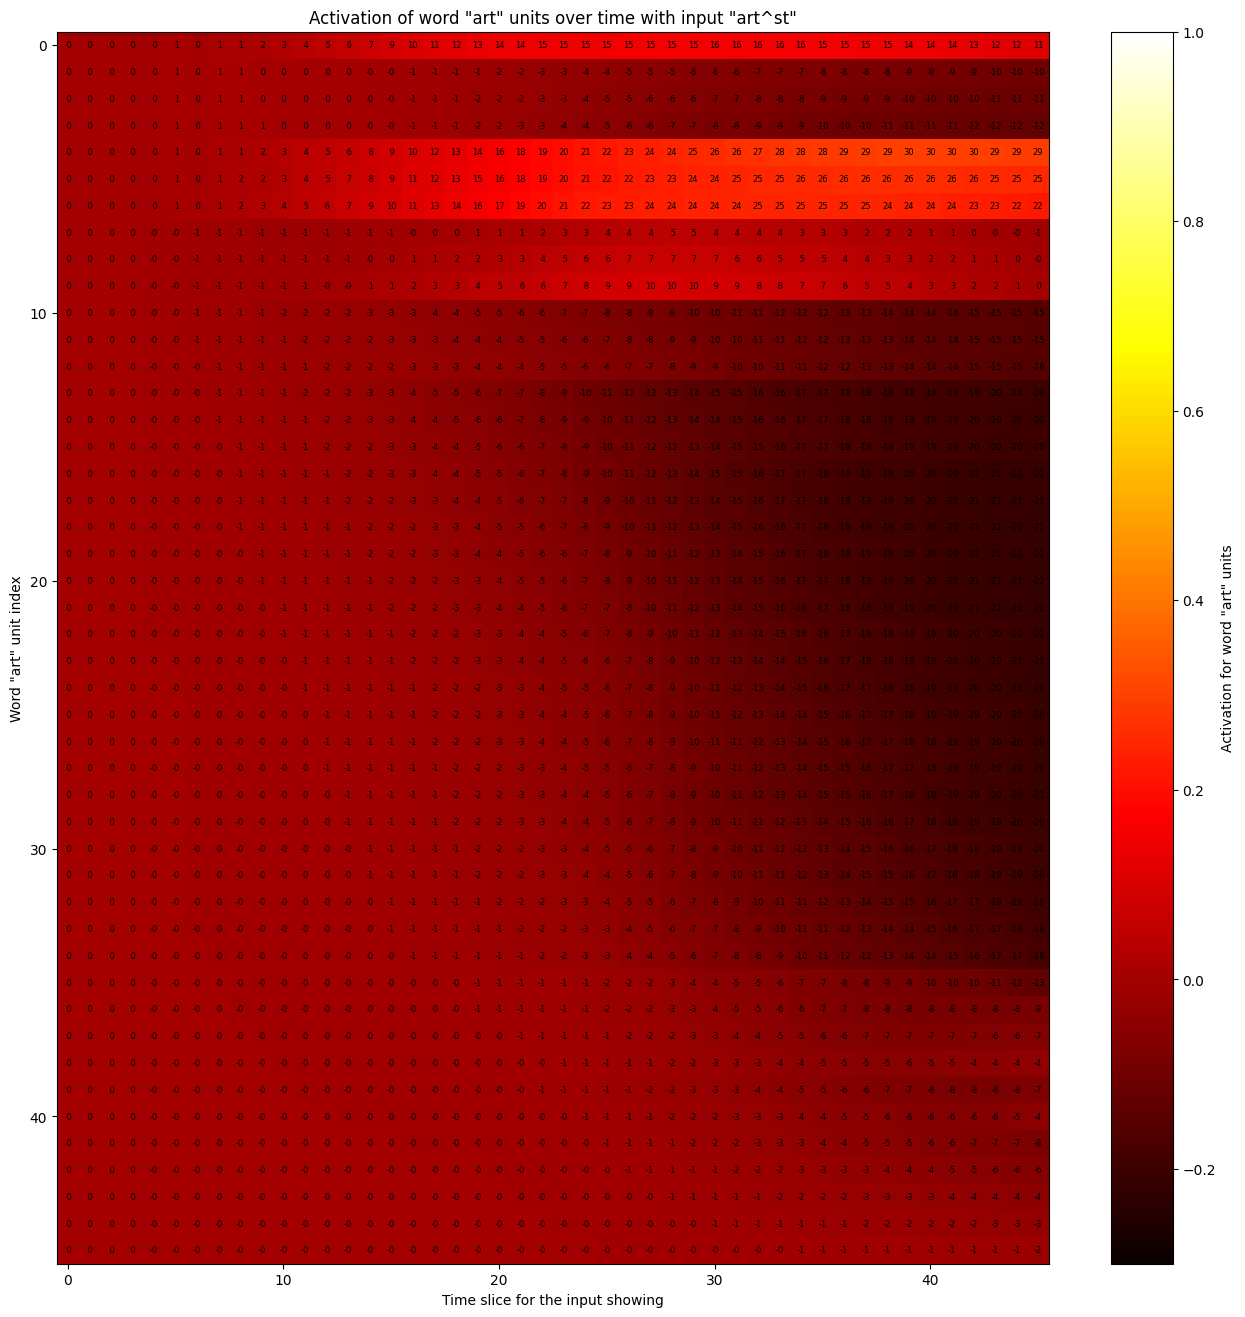

(46,)


,Time,Max Activation Word,Probability
29,29,art^st,0.034390
9,9,art^st,0.031458
8,8,art^st,0.031004
7,7,art^st,0.030639
4,4,art^st,0.028129
5,5,art^st,0.027805
6,6,art^st,0.027764
0,0,art^st,0.027654
37,37,art^st,0.024850
28,28,karp^t,0.024440


In [12]:
plot_word_unit_responses("bar", word_values_agg, slice_num, input_string)
plot_word_unit_responses("art^st", word_values_agg, slice_num, input_string)
plot_word_unit_responses("art", word_values_agg, slice_num, input_string)

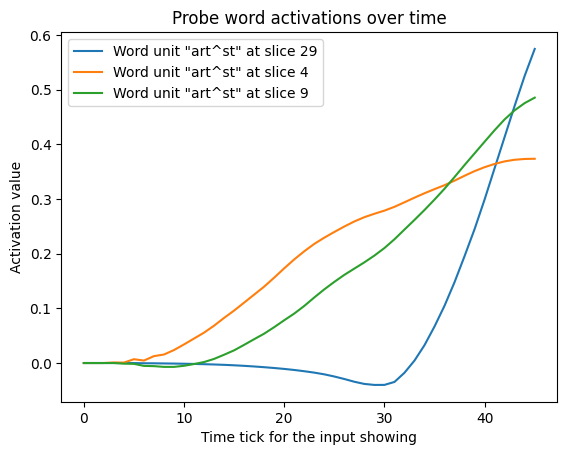

In [13]:
plot_probe_responses(probe_values, probes)